In [1]:
suppressPackageStartupMessages({

    library(VariantAnnotation)
    library(tidyverse)
    library(magrittr)
    library(here)
    library(bdkn)
    library(rtracklayer)

})

In [2]:
mendez_a00_counts <- tibble(a = 1434, d = 305, e = 19, f = 1591)

In [3]:
mendez_a00_counts %>% mutate(e / d, d / a, (a + d) / f)

a,d,e,f,e/d,d/a,(a + d)/f
1434,305,19,1591,0.06229508,0.2126918,1.093023


In [4]:
emh_ages <- tribble(
    ~ustishim, ~bichon, ~kk1, ~loschbour, ~mota,
    45000, 13665, 9720, 8050, 4500
)
emh_ages

ustishim,bichon,kk1,loschbour,mota
45000,13665,9720,8050,4500


In [5]:
source(here("src/utils.R"))

In [6]:
gt <- read_gt(here("data/vcf/merged_full.vcf.gz"))

In [7]:
modern <- colnames(gt) %>% str_subset("reference|^S_")

In [8]:
ancient <- c("kk1", "mota", "bichon", "loschbour", "ustishim")

In [9]:
site_patterns <- function(df, w, x, y, z) {
    tibble(
        a = as.integer(df[[w]] == df[[x]] & df[[y]] == df[[z]] & df[[w]] != df[[y]]),
        d = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[z]] & df[[w]] != df[[y]]),
        e = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[y]] & df[[w]] != df[[z]]),
        f = as.integer(df[[w]] == df[[y]] & df[[w]] == df[[z]] & df[[w]] != df[[x]])
    )
}

In [10]:
count_patterns <- function(gt, w, x, y, z) {
    df <- gt[, c(w, x, y, z)] %>% .[complete.cases(.), ]
    site_patterns(df, w, x, y, z) %>% summarise_all(sum) %>% mutate(total = nrow(df))
}

In [11]:
a00_pat <- count_patterns(gt, w = "chimp", x = "a00", y = "reference", z = "ustishim")

In [12]:
a00_pat

a,d,e,f,total
1015,230,10,1046,203096


In [17]:
a00_counts <- 
    map_dfr(modern, function(ref) {
        map_dfr(ancient, function(anc) {
            count_patterns(gt, w = "chimp", x = "a00", y = ref, z = anc) %>%
                mutate(ref = ref, anc = anc)
        })
    })

In [13]:
a00_counts %>% filter(ref == "reference") %>% arrange(e) %>% mutate(e / d, d / a, (a + d) / f)

ERROR: Error in eval(lhs, parent, parent): object 'a00_counts' not found


In [81]:
a00_counts %>% filter(ref == "reference") %>% arrange(e) %>% mutate(e / d, d / a, (a + d) / f)

a,d,e,f,total,ref,anc,e/d,d/a,(a + d)/f
1015,230,10,1046,203096,reference,ustishim,0.04347826,0.2266010,1.190249
550,113,65,580,113943,reference,bichon,0.57522124,0.2054545,1.143103
841,148,108,870,168057,reference,kk1,0.72972973,0.1759810,1.136782
1008,239,157,1061,201974,reference,loschbour,0.65690377,0.2371032,1.175306
804,220,217,931,175849,reference,mota,0.98636364,0.2736318,1.099893


In [82]:
a00_counts %>% filter(ref == "S_Han-2") %>% arrange(e) %>% mutate(e / d, d / a, (a + d) / f)

a,d,e,f,total,ref,anc,e/d,d/a,(a + d)/f
1009,190,8,1040,201874,S_Han-2,ustishim,0.04210526,0.1883053,1.152885
544,110,63,577,113245,S_Han-2,bichon,0.57272727,0.2022059,1.133449
835,165,104,864,167029,S_Han-2,kk1,0.63030303,0.1976048,1.157407
1000,203,155,1055,200748,S_Han-2,loschbour,0.76354680,0.2030000,1.140284
796,228,214,925,174787,S_Han-2,mota,0.93859649,0.2864322,1.107027


In [197]:
emh_ages

ustishim,bichon,kk1,loschbour,mota
45000,13665,9720,8050,4500


In [134]:
total <- 6913053

In [219]:
ancient <- "ustishim"

In [220]:
counts <- a00_counts %>% filter(ref == "reference", anc == ancient)

In [221]:
counts

a,d,e,f,total,ref,anc
1015,230,10,1046,203096,reference,ustishim


In [222]:
(muts_per_year <- (counts$d - counts$e) / emh_ages[[ancient]])

[1] 0.004888889

In [223]:
muts_per_year / total # mutation rate within a region (get the proper total amount of sequence
# don't filter out for only het sites!)

[1] 7.071968e-10

In [224]:
counts$f / muts_per_year

[1] 213954.5

In [225]:
(counts$a + counts$d) / muts_per_year 

[1] 254659.1

In [226]:
counts$d / muts_per_year 

[1] 47045.45

In [227]:
filter(a00_counts, ref == "reference", anc == "kk1") %>%
    { (.$d - .$e) / emh_ages[[.$anc]] }

[1] 0.004115226

In [228]:
filter(a00_counts, ref == "reference", anc == "bichon") %>%
    { (.$d - .$e) / emh_ages[[.$anc]] }

[1] 0.003512623

In [229]:
filter(a00_counts, ref == "reference", anc == "loschbour") %>%
    { (.$d - .$e) / emh_ages[[.$anc]] }

[1] 0.01018634

Joining, by = "anc"


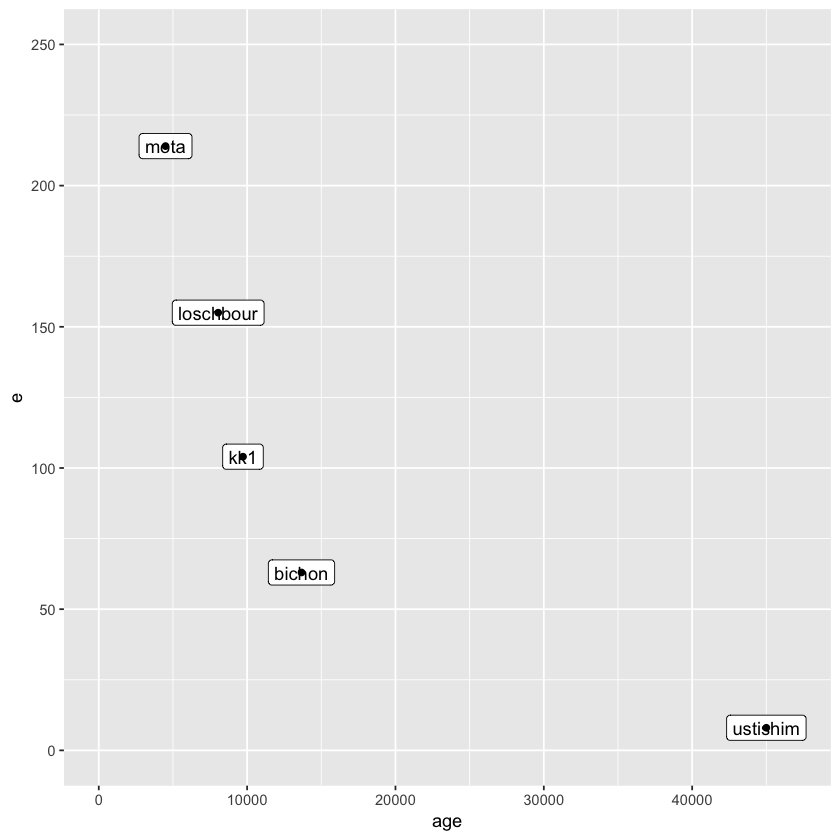

In [240]:
filter(a00_counts, ref == "S_Han-2") %>%
    inner_join(gather(emh_ages, anc, age)) %>%
    ggplot(aes(age, e)) + geom_label(aes(label = anc)) + geom_point() +
    ylim(0, 250) + xlim(0, 47000)